In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

if __package__ is None:
    import sys, os
    sys.path.append(os.path.realpath("../"))
from keras.layers import Input, GRU,RepeatVector
from keras.engine import Model
#from CMS_Deep_Learning.layers.ptr_net import Ptr_Layer
from CMS_Deep_Learning.layers.slice import Slice
from CMS_Deep_Learning.io import flatten
from keras import backend as K#,initializers
import numpy as np
import theano


Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:07:00.0)


In [2]:
#def giniSparsity(softmax_matrix, sparsity_coeff=.025):
#    return sparsity_coeff * K.sum(K.sum(K.sum(softmax_matrix*(1.0-softmax_matrix)))) / K.prod(K.shape(softmax_matrix)) 
#K.eval(giniSparsity(.002*np.random.random((100,100,100))) )

In [3]:
from keras.engine.topology import Layer,initializations
from keras import backend as K#,initializers
from keras.regularizers import Regularizer
#import theano
#import tensorflow as tf 

def softmax(x, axis=-1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    #if ndim == 2:
    #    return K.softmax(x)
    if ndim >= 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

def giniSparsity(softmax_matrix, sparsity_coeff=.025):
    return sparsity_coeff * K.sum(K.sum(K.sum(softmax_matrix*(1.0-softmax_matrix)))) / K.prod(K.cast((K.shape(softmax_matrix)),'float32')) 
#K.eval(giniSparsity(.002*np.random.random((100,100,100))) ) 

class Ptr_Layer(Layer):
    def __init__(self, attention_width,implementation='custom', seq_len=None,sparsity_coeff=1000.0, return_U=False,**kwargs):
       
        self.supports_masking = True
        self.init = initializations.get('glorot_uniform')
        self.attention_width = attention_width
        self.sparsity_coeff = sparsity_coeff
        self.implementation = implementation
        self.seq_len = seq_len
        self.return_U = return_U
        super(Ptr_Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        print("IMPLEMENTATION: %r" % self.implementation)
        assert len(input_shape) >= 2
        
        if(self.implementation == 'custom' or self.implementation == 'custom_T'):
            assert self.attention_width == input_shape[1][-2], "attention width %r != seq size %r" %(self.attention_width,input_shape[1][-2])
        
        # self.attention_width = input_shape[1][-1]
        self.W1 = self.add_weight((self.attention_width ,input_shape[1][-1]), #(att_dim, recurrent_dim)
                                 initializer=self.init,
                                 name='{}_W1'.format(self.name))
        self.W2 = self.add_weight((self.attention_width ,input_shape[2][-1] if len(input_shape) > 2 else input_shape[1][-1]), #(att_dim, recurrent_dim)
                                  initializer=self.init,
                                  name='{}_W2'.format(self.name))
        if(self.implementation != 'custom' and self.implementation != 'custom_T'):
            self.v = self.add_weight((self.attention_width,1),
                                      initializer=self.init,
                                      name='{}_v'.format(self.name))
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        if(self.return_U):
            return [None,None]
        else:
            return None

    def call(self, inp, mask=None):
        assert isinstance(inp,list) and len(inp) >= 2, "Bad input expecting list of input,encoder,decoder"
        
        if(len(inp) == 3):
            x_T,e_T,d_T = inp
        elif(len(X) == 2):
            x_T,e_T = inp
            d_T = e_T
        
        #Let x be the inputs as column vectors
        # (batch_size ,sequence_len, feature_dim) -> (batch_size ,feature_dim,sequence_len)
        x = K.permute_dimensions(x_T,(0,2,1))
        
        
        if(K.backend() == "tensorflow"):
            assert self.seq_len != None, 'Must set Ptr_Layer(seq_len=?) if using Tensorflow'
            seq_len = self.seq_len
        else:
            seq_len = K.shape(e_T)[1]
        # Shape key:
        # x_T:  #(batch_size ,sequence_len, feature_dim)
        # e_T:  #(batch_size ,sequence_len, recurrent_dim)
        # d_T:  #(batch_size ,sequence_len, recurrent_dim)
        #*_T indicates row vectors
           
        #(batch_size ,sequence_len, recurrent_dim) * (recurrent_dim,att_dim) -> #(batch_size ,sequence_len,att_dim)
        _e_T, _d_T = K.dot(e_T,K.transpose(self.W1)), K.dot(d_T, K.transpose(self.W2)) # (batch_size ,sequence_len, att_dim)
        _e, _d = K.permute_dimensions(_e_T,(0,2,1)), K.permute_dimensions(_d_T,(0,2,1)) # (batch_size ,att_dim, sequence_len)
        #_e = theano.printing.Print('_e', attrs=['shape'])(_e)
        #_d = theano.printing.Print('_d', attrs=['shape'])(_d)
        
        def Tmap(fn, arrays, dtype='float32'):
            # assumes all arrays have same leading dim
            indices = K.range(K.shape(arrays[0])[0])
            out = K.map_fn(lambda ii: fn(*[array[ii] for array in arrays]), indices, dtype=dtype)
            return out
        
        
        
        if(self.implementation == 'ptr_net'):
            print("PTR_NET")
            
            E_T = K.repeat_elements(K.expand_dims(_e_T, dim=1), seq_len, axis=1) # (batch_size ,sequence_len, sequence_len, att_dim)
            D_T = K.repeat_elements(K.expand_dims(_d_T, dim=1), seq_len, axis=1) # (batch_size ,sequence_len, sequence_len, att_dim)

            D = K.permute_dimensions(D_T,(0,2,1,3)) # (batch_size ,sequence_len, sequence_len, att_dim)

            u = K.squeeze(K.dot(K.tanh(E_T + D),self.v),axis=-1) # (batch_size ,sequence_len, sequence_len)
            u = K.permute_dimensions(u, (0,2,1))
            #axis=2 is row axis therefore u*x has columns that are linear combos of x
            u = softmax(u,axis=2) # (batch_size ,sequence_len, sequence_len) 
        elif(self.implementation == 'ptr_net_scan'):
            def _ptr_net_u(_e_T,_d_T):
                __E_T = K.repeat_elements(K.expand_dims(_e_T, dim=0), seq_len, axis=0) # (sequence_len, sequence_len, att_dim)
                __D_T = K.repeat_elements(K.expand_dims(_d_T, dim=0), seq_len, axis=0) # (sequence_len, sequence_len, att_dim)


                __D = K.permute_dimensions(__D_T,(1,0,2)) # (sequence_len, sequence_len, att_dim)

                u = K.dot(K.tanh(__E_T + __D),self.v) # (sequence_len, sequence_len)
                u = K.squeeze(u,axis=-1)
                u = K.permute_dimensions(u, (1,0))
                u = softmax(u,axis=1) # (sequence_len, sequence_len) 

                return u
            assert K.backend()=='tensorflow', 'ptr_net_scan only works with tensorflow backend'
            import tensorflow as tf
            u = tf.map_fn(lambda x: _ptr_net_u(x[0], x[1]), (_e_T,_d_T), dtype=tf.float32)
            
        elif(self.implementation == 'custom'):
            #only onto if att_dim == sequence_len
            u = _e + _d_T           ## (batch_size ,att_dim, att_dim)
            u = softmax(u,axis=2)   ## (batch_size ,att_dim, att_dim)  
        elif(self.implementation == 'custom_T'):
            #only onto if att_dim == sequence_len
            u = _e_T + _d           ## (batch_size ,att_dim, att_dim)
            u = softmax(u,axis=2)   ## (batch_size ,att_dim, att_dim)  
        else:
            raise ValueError("implementation not recognized: %r" % self.implementation)
            
        
        self.add_loss(giniSparsity(u,self.sparsity_coeff))
        
        u_T = K.permute_dimensions(u, (0, 2, 1))
        #For some reason batchdot dots the transposes (i.e batch_dot(X,Y) = X^TY^T = (YX)^T )
        #Therefore batch_dot(U^T,X) = UX^T -> X_sorted^T
        x_T = K.batch_dot(u_T,x, axes=[1, 2]) 
        
        #x_T = K.permute_dimensions(soft_sorted_x, (0, 2, 1))
        if(self.return_U):
            return [x_T, u] #+K.sum(K.sum(K.sum(u)))#+ K.sum(K.sum(K.sum(_e))) + K.sum(K.sum(K.sum(_d))) 
        else:
            return x_T

    def get_output_shape_for(self, input_shape):
        if(self.return_U):
            return [tuple(input_shape[0]),tuple((input_shape[0][0],input_shape[0][-2],input_shape[0][-2]))]
        else:
            return tuple(input_shape[0])
            





In [8]:
from keras.engine.topology import Layer,initializations
from keras import backend as K#,initializers
from keras.regularizers import Regularizer

class WanderingGaussians(Layer):
    def __init__(self, seq_len,return_U=False,**kwargs):
        self.seq_len = seq_len
        self.init = initializations.get('glorot_uniform')
        self.return_U = return_U
        super(WanderingGaussians, self).__init__(**kwargs)

    def build(self, input_shape):
                
        self.W = self.add_weight((self.seq_len,input_shape[1][-1]), #(att_dim, recurrent_dim
                                 initializer=self.init,
                                 name='{}_W'.format(self.name))
        
        self.sigma = K.variable(np.ones((1,1))*self.seq_len)
        self.trainable_weights.append(self.sigma)
        #self.sigma = self.add_weight((1,1), #(att_dim, recurrent_dim
        #                         initializer=lambda x:
        #                         name='{}_sigma'.format(self.name))
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        if(self.return_U):
            return [None,None]
        else:
            return None

    def call(self, inp, mask=None):
        x_T,e_T = inp
        x = K.permute_dimensions(x_T,(0,2,1))
        
        g_centers = K.dot(self.W,e_T)
        
        g_centers = theano.printing.Print('g_centers', attrs=['shape'])(g_centers)
        
        #locs = K.expand_dims(K.arange(self.seq_len),dim=0)
        #locs = K.repeat_elements(locs,self.seq_len,axis=0)
        #diffs = locs - g_centers
        #diffs = theano.printing.Print('diffs', attrs=['shape'])(diffs)
        #R = K.exp(-K.square(diffs)/2.0*self.sigma)
        
        
        
        #u = softmax(R,axis=2)   ## (batch_size ,att_dim, att_dim)  
        #u_T = K.permute_dimensions(u, (0, 2, 1))
        #For some reason batchdot dots the transposes (i.e batch_dot(X,Y) = X^TY^T = (YX)^T )
        #Therefore batch_dot(U^T,X) = UX^T -> X_sorted^T
        #x_T = K.batch_dot(u_T,x, axes=[1, 2]) 
        a = inp[0] + K.sum(K.sum(K.sum(g_centers))) + K.sum(K.sum(self.sigma))
        return [a,g_centers]
        
    def get_output_shape_for(self, input_shape):
        if(self.return_U):
            return [tuple(input_shape[0]),tuple((input_shape[0][0],input_shape[0][-2],input_shape[0][-2]))]
        else:
            return tuple(input_shape[0])
        


In [9]:
from keras.engine.topology import Layer,initializations,Merge
def null_cost(y_true, y_pred):
    # output itself is cost and must be minimized
    return K.sum(y_pred)*0 + K.sum(y_true)*0
def buildModel(sparsity_coeff=0.0):
    x = Input(shape=(SEQ_LEN, 1), name="input")
    e = GRU(8000,return_sequences=False)(x)
    #s = Slice("[-1,:]")(e)
    # s = Slice('[-1,:]')(e)
    # s = theano.printing.Print("s")(s)
    #r = RepeatVector(SEQ_LEN)(s)
    #m = Merge(mode='concat',concat_axis=2)([r,x])
    #d = GRU(128,return_sequences=True)(m)
    p,u = WanderingGaussians(SEQ_LEN,return_U=True)([x,e])

    model = Model(input=x, output=[p,u], name='test')
    model.compile(optimizer='adam',loss=['mse',null_cost],loss_weights=[1., 0.0])
    return model

In [10]:
SEQ_LEN = 50
DATA_SHAPE =[None, SEQ_LEN, 1]

inp = np.random.randint(size=tuple([50000]+DATA_SHAPE[1:]),low=0,high=1000)/1000.0
indicies = np.argsort(inp[:, :, 0])
target = np.array([np.take(inp[i], indicies[i], axis=-2) for i in range(inp.shape[0])])

val = np.random.randint(size=tuple([10000]+DATA_SHAPE[1:]),low=0,high=500)/1000.0
indicies = np.argsort(val[:, :, 0])
val_target = np.array([np.take(val[i], indicies[i], axis=-2) for i in range(val.shape[0])])

In [11]:
sweep = [0.0,0.00001,0.0001,0.001,0.01,0.025,0.1,1.0]
mses = []
models = []
runs = {}
for n in range(3):
    for sp in [0.0]:
        model = buildModel(sp)
        mse_vals = []
        for i in range(40):
            model.fit(inp, [target,np.ones((target.shape[0],SEQ_LEN,SEQ_LEN))], nb_epoch=1,batch_size=100)
            p,u = model.predict(val)
            val_mse = float(K.eval(K.mean(K.pow(p - val_target, 2))))
            mse_vals.append(val_mse )
            print("VAL_MSE:", val_mse)
        models.append(model)
        #val_mse = np.random.randint(size=1,low=0,high=100)[0]#(min(mse_vals))
        #print(runs.get(sp,[]))
        runs[sp] = runs.get(sp,[]) + [min(mse_vals)]
print(runs)
json.dump(runs, open(os.path.abspath("/home/dweitekamp/custom_out1.txt"),'w'))

Epoch 1/1


GpuArrayException: out of memory
Apply node that caused the error: GpuAllocEmpty{dtype='float32', context_name=None}(TensorConstant{51}, Shape_i{0}.0, TensorConstant{8000})
Toposort index: 36
Inputs types: [TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar)]
Inputs shapes: [(), (), ()]
Inputs strides: [(), (), ()]
Inputs values: [array(51), array(100), array(8000)]
Outputs clients: [[GpuIncSubtensor{InplaceSet;:int64:}(GpuAllocEmpty{dtype='float32', context_name=None}.0, Rebroadcast{0}.0, Constant{1})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
print(sweep)
print(mses)
print(runs)
import json
d = {"one":1, "two":2}

#50 floats btw 0-1 
    #w/o tanh ptr_net
    #Does not converge
    #Tanh ptr_net
    #0.0006992769549385588
    
    #w/o tanh custom
    #0.0027380140176726468
    #Tanh custom
    #0.008146504258126774
    
    #ptr_net 5 epoch:
    #[0.0, 0.001, 0.01, 0.1, 1.0, 10.0]
    #[0.0005530958605927241, 0.0008726149090503212, 0.000940361804486735, 0.0006479378772081163, 0.002113587790538396, 0.00886053613683831]
    
    #ptr_net 15 epoch:
    #[0.0, 1e-05, 0.0001, 0.001, 0.01, 0.025, 0.1, 1.0]
    #[0.0005856020492227538, 0.000435507757379088, 0.0005835100906981886, 0.0007385180880908348, 0.00038265960976375526, 0.0004894350985301985, 0.00042241677262379437, 0.000939572834186924]


#print("VAL_LOSS:", model.evaluate(val,val_target,batch_size=1))
#print("VAL_LOSS:", model.evaluate(val,val_target,batch_size=10))
#print("VAL_LOSS:", model.evaluate(val,val_target,batch_size=100))

In [ ]:
from keras.engine.topology import Layer,initializations,Merge
def null_cost(y_true, y_pred):
    # output itself is cost and must be minimized
    return K.sum(y_pred)*0 + K.sum(y_true)*0
def buildModel(sparsity_coeff=0.0):
    x = Input(shape=(SEQ_LEN, 1), name="input")
    e = GRU(128,return_sequences=True)(x)
    s = Slice("[-1,:]")(e)
    # s = Slice('[-1,:]')(e)
    # s = theano.printing.Print("s")(s)
    r = RepeatVector(SEQ_LEN)(s)
    m = Merge(mode='concat',concat_axis=2)([r,x])
    d = GRU(128,return_sequences=True)(m)
    p,u = Ptr_Layer(50,sparsity_coeff=sparsity_coeff,return_U=True,
                    implementation='ptr_net',seq_len=SEQ_LEN)([x,e,d])

    model = Model(input=x, output=[p,u], name='test')
    model.compile(optimizer='adam',loss=['mse',null_cost],loss_weights=[1., 0.0])
    return model

In [95]:
'''Epoch 1/1
50000/50000 [==============================] - 780s - loss: 0.0016   
('VAL_MSE:', 8.391598572468554e-05)
Epoch 1/1
50000/50000 [==============================] - 786s - loss: 1.3540e-04   
('VAL_MSE:', 0.00015946542762654568)
Epoch 1/1
50000/50000 [==============================] - 781s - loss: 1.3643e-04   
('VAL_MSE:', 7.359234000334871e-05)
Epoch 1/1
50000/50000 [==============================] - 790s - loss: 1.1043e-04   
('VAL_MSE:', 0.00037620730748726995)
Epoch 1/1
50000/50000 [==============================] - 778s - loss: 9.5742e-05   
('VAL_MSE:', 0.0004603614554866676)
Epoch 1/1
50000/50000 [==============================] - 793s - loss: 8.6783e-05   
('VAL_MSE:', 0.0006976922938582105)
Epoch 1/1
50000/50000 [==============================] - 766s - loss: 8.3102e-05   
('VAL_MSE:', 0.0010426845653969696)
Epoch 1/1
50000/50000 [==============================] - 781s - loss: 8.1857e-05   
('VAL_MSE:', 0.0010114745970606362)
Epoch 1/1
50000/50000 [==============================] - 776s - loss: 1.7436e-04   
('VAL_MSE:', 0.0001110254697785855)
Epoch 1/1
32700/50000 [==================>...........] - ETA: 260s - loss: 1.2367e-04
'''

"Epoch 1/1\n50000/50000 [==============================] - 780s - loss: 0.0016   \n('VAL_MSE:', 8.391598572468554e-05)\nEpoch 1/1\n50000/50000 [==============================] - 786s - loss: 1.3540e-04   \n('VAL_MSE:', 0.00015946542762654568)\nEpoch 1/1\n50000/50000 [==============================] - 781s - loss: 1.3643e-04   \n('VAL_MSE:', 7.359234000334871e-05)\nEpoch 1/1\n50000/50000 [==============================] - 790s - loss: 1.1043e-04   \n('VAL_MSE:', 0.00037620730748726995)\nEpoch 1/1\n50000/50000 [==============================] - 778s - loss: 9.5742e-05   \n('VAL_MSE:', 0.0004603614554866676)\nEpoch 1/1\n50000/50000 [==============================] - 793s - loss: 8.6783e-05   \n('VAL_MSE:', 0.0006976922938582105)\nEpoch 1/1\n50000/50000 [==============================] - 766s - loss: 8.3102e-05   \n('VAL_MSE:', 0.0010426845653969696)\nEpoch 1/1\n50000/50000 [==============================] - 781s - loss: 8.1857e-05   \n('VAL_MSE:', 0.0010114745970606362)\nEpoch 1/1\n50000/

('VAL_MSE:', 0.04030945294692414)
(50, 50)


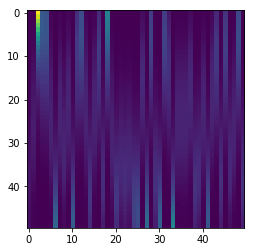

('PREDICT:', [97.66316986083984, 105.26632690429688, 100.72516632080078, 105.54948425292969, 101.53494262695312, 115.72566986083984, 89.9979248046875, 111.00701904296875, 102.1955795288086, 103.30500793457031, 93.25000762939453, 115.79753112792969, 105.50733184814453, 92.3228988647461, 90.3014144897461, 111.6373291015625, 102.5931625366211, 102.65575408935547, 99.6197280883789, 111.34857177734375, 90.11139678955078, 121.17964172363281, 111.3847885131836, 103.0531005859375, 91.0475845336914, 107.00244903564453, 107.5797119140625, 103.32713317871094, 97.87638854980469, 108.49292755126953, 103.39321899414062, 93.65983581542969, 99.27876281738281, 109.53147888183594, 105.21348571777344, 108.18997192382812, 104.13240814208984, 118.89781951904297, 93.42413330078125, 113.54312896728516, 105.24564361572266, 106.08418273925781, 95.20858764648438, 117.45650482177734, 109.02674102783203, 94.34076690673828, 92.4881591796875, 115.39363861083984, 108.41148376464844, 106.51969909667969])
('TRUE   :',

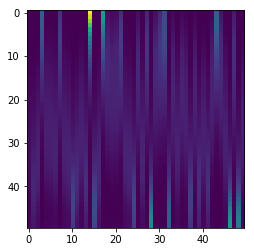

('PREDICT:', [92.32128143310547, 79.95952606201172, 92.09846496582031, 93.04183959960938, 89.92059326171875, 72.37836456298828, 102.00945281982422, 90.62364959716797, 96.30706787109375, 88.71830749511719, 99.00659942626953, 94.58488464355469, 94.44972229003906, 82.0986328125, 90.55805206298828, 92.78534698486328, 81.35181427001953, 89.8228759765625, 98.30530548095703, 83.69970703125, 97.52587127685547, 87.92257690429688, 99.08495330810547, 82.15467071533203, 100.27989959716797, 93.1300048828125, 92.77839660644531, 83.45144653320312, 100.43480682373047, 92.64566040039062, 80.55912017822266, 79.72309112548828, 96.77269744873047, 84.27406311035156, 95.25016021728516, 94.80587768554688, 92.49192810058594, 75.1556167602539, 103.89002990722656, 93.52070617675781, 98.0987548828125, 90.87079620361328, 100.79576110839844, 98.14112854003906, 96.40730285644531, 84.23357391357422, 94.94165802001953, 97.44720458984375, 84.88795471191406, 91.494873046875])
('TRUE   :', [2.0, 7.0, 20.0, 34.0, 45.0, 5

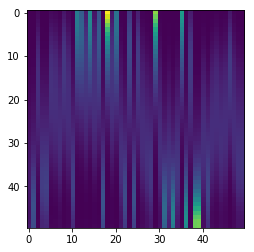

('PREDICT:', [93.86768341064453, 109.59796142578125, 96.28905487060547, 110.48607635498047, 85.65556335449219, 110.97444915771484, 104.6754379272461, 97.37894439697266, 83.62489318847656, 116.0840072631836, 105.46417999267578, 89.92295837402344, 93.13206481933594, 103.2735366821289, 99.55298614501953, 91.34845733642578, 94.67635345458984, 107.943115234375, 92.39139556884766, 118.6773910522461, 102.7582015991211, 102.86323547363281, 79.8987808227539, 111.07046508789062, 105.60789489746094, 96.54518127441406, 90.787353515625, 108.40242767333984, 96.57520294189453, 103.0467300415039, 92.89280700683594, 100.54698944091797, 99.557373046875, 113.97532653808594, 98.75277709960938, 115.19139099121094, 89.20771026611328, 113.51173400878906, 108.29113006591797, 100.17280578613281, 86.3984146118164, 119.2531509399414, 110.65120697021484, 92.80134582519531, 95.65508270263672, 107.80264282226562, 106.37701416015625, 95.7838363647461, 91.32666015625, 109.2955322265625])
('TRUE   :', [14.0, 18.0, 31.

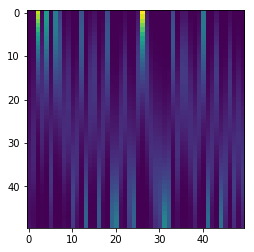

('PREDICT:', [139.48170471191406, 121.60786437988281, 116.10824584960938, 100.73623657226562, 127.97696685791016, 114.56069946289062, 119.83931732177734, 111.67339324951172, 132.97525024414062, 122.88797760009766, 114.6944351196289, 118.97985076904297, 120.7855224609375, 115.333984375, 124.1650390625, 129.73675537109375, 133.47650146484375, 112.4356460571289, 134.7777099609375, 119.85040283203125, 118.230712890625, 109.89689636230469, 115.47673797607422, 124.7765884399414, 127.17628479003906, 104.4619369506836, 130.15048217773438, 116.83428192138672, 117.74503326416016, 120.17528533935547, 127.0675048828125, 123.0401611328125, 144.8060302734375, 124.7339096069336, 120.45915222167969, 104.66284942626953, 131.5129852294922, 119.4521484375, 123.9061050415039, 114.29802703857422, 136.71435546875, 128.55616760253906, 116.73950958251953, 121.50946807861328, 125.3857192993164, 122.77763366699219, 130.06332397460938, 125.21268463134766, 134.3080291748047, 110.42501068115234])
('TRUE   :', [10.

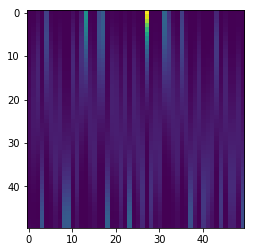

('PREDICT:', [112.75667572021484, 106.95527648925781, 86.65985107421875, 110.50406646728516, 110.67222595214844, 100.0546875, 97.1994857788086, 112.33555603027344, 114.33601379394531, 106.71788024902344, 95.22335052490234, 112.05565643310547, 97.75489044189453, 102.66287231445312, 108.0418472290039, 109.82115936279297, 97.75934600830078, 117.7937240600586, 103.59467315673828, 102.18657684326172, 93.44709777832031, 114.53741455078125, 107.2183837890625, 108.41658782958984, 95.92078399658203, 120.60735321044922, 105.09020233154297, 101.12455749511719, 101.63633728027344, 104.41011810302734, 100.98995208740234, 113.45536041259766, 115.26207733154297, 110.12250518798828, 89.10254669189453, 112.76349639892578, 114.4307861328125, 102.43240356445312, 99.26548767089844, 114.33382415771484, 118.60139465332031, 108.79166412353516, 96.63853454589844, 116.19071960449219, 103.28018188476562, 106.38045501708984, 109.13774871826172, 112.74710845947266, 101.29871368408203, 119.46916198730469])
('TRUE 

In [133]:
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True,threshold=500000)
p,u = model.predict(val)
print("VAL_MSE:", float(K.eval(K.mean(K.pow(p - val_target, 2)))))
for a,b,c in zip(p[:5]*1000.0,val_target[:5]*1000.0,u[:5]):
    print(c.shape)
    plt.imshow(c)
    plt.show()
    print("PREDICT:",flatten(a.tolist()))
    print("TRUE   :",flatten(b.tolist()))
#print([np.concatenate(list(x), axis=-1) for ])
#print(target)

In [ ]:
'''CUSTOM 50 ints mapped to [0,1]
('VAL_MSE:', 0.001569600218234435)
('PREDICT:', [14.08072566986084, 24.556095123291016, 28.295637130737305, 30.411785125732422, 33.13698196411133, 37.32411193847656, 46.1008186340332, 53.2075080871582, 63.4344596862793, 72.48200988769531, 85.3075942993164, 93.4632568359375, 98.74871826171875, 108.7425765991211, 110.91658020019531, 123.70269775390625, 134.5385284423828, 143.88876342773438, 159.08541870117188, 181.8461456298828, 190.42434692382812, 203.7500457763672, 220.6626434326172, 239.72796630859375, 245.00320434570312, 246.1892547607422, 236.80545043945312, 245.6599884033203, 232.46725463867188, 239.04486083984375, 245.08265686035156, 248.84344482421875, 264.63299560546875, 285.3381652832031, 289.361083984375, 299.7632751464844, 313.9530944824219, 323.9080505371094, 322.595947265625, 334.1806335449219, 332.671875, 323.8444519042969, 335.371337890625, 339.9270935058594, 359.6188659667969, 392.69171142578125, 423.1754455566406, 479.6092224121094, 546.0584716796875, 667.3662719726562])
('TRUE   :', [2.0, 15.0, 30.0, 33.0, 45.0, 51.0, 63.0, 65.0, 71.0, 76.0, 81.0, 91.0, 92.0, 93.0, 98.0, 103.0, 115.0, 127.0, 163.0, 188.0, 192.0, 193.0, 208.0, 223.0, 225.0, 229.0, 238.0, 247.0, 257.0, 263.0, 265.0, 272.0, 277.0, 282.0, 291.0, 293.0, 297.0, 313.0, 347.0, 350.0, 350.0, 368.0, 385.0, 410.0, 426.0, 436.0, 446.0, 450.0, 452.0, 484.0])
('PREDICT:', [17.798559188842773, 33.463016510009766, 39.10608673095703, 43.00112533569336, 44.50833511352539, 48.93029022216797, 58.13621139526367, 64.9529037475586, 75.26228332519531, 85.29837799072266, 102.46138763427734, 113.64612579345703, 124.90634155273438, 140.658935546875, 146.15133666992188, 162.67030334472656, 172.6062469482422, 179.36094665527344, 194.64930725097656, 214.78004455566406, 219.95840454101562, 231.04476928710938, 246.4239959716797, 264.68646240234375, 269.5362548828125, 272.99102783203125, 266.89630126953125, 275.0792236328125, 260.5761413574219, 267.4671936035156, 272.8695373535156, 275.08282470703125, 289.3886413574219, 310.0047302246094, 313.9212951660156, 327.7631530761719, 342.7054748535156, 356.8041076660156, 354.9676208496094, 364.4736328125, 364.2120361328125, 353.3575744628906, 363.51544189453125, 365.5188903808594, 381.6290283203125, 414.7137756347656, 445.9398498535156, 501.1640930175781, 568.592529296875, 690.3679809570312])
('TRUE   :', [24.0, 35.0, 42.0, 46.0, 54.0, 63.0, 67.0, 67.0, 68.0, 71.0, 119.0, 124.0, 148.0, 151.0, 151.0, 153.0, 162.0, 174.0, 180.0, 212.0, 214.0, 216.0, 219.0, 234.0, 243.0, 247.0, 257.0, 266.0, 274.0, 275.0, 282.0, 289.0, 294.0, 299.0, 320.0, 334.0, 343.0, 359.0, 387.0, 390.0, 393.0, 403.0, 404.0, 420.0, 427.0, 445.0, 477.0, 485.0, 491.0, 496.0])
('PREDICT:', [15.987208366394043, 22.936832427978516, 24.929330825805664, 23.940183639526367, 26.281198501586914, 28.679780960083008, 35.26726150512695, 41.234291076660156, 49.22452926635742, 57.713165283203125, 69.93475341796875, 81.98285675048828, 92.2459487915039, 106.03779602050781, 111.96952056884766, 127.2327880859375, 139.74241638183594, 149.53489685058594, 164.30023193359375, 187.7772979736328, 195.0567169189453, 207.03494262695312, 223.97085571289062, 243.4896697998047, 249.49842834472656, 252.11972045898438, 244.68350219726562, 256.1998596191406, 243.84954833984375, 249.20632934570312, 256.2884826660156, 260.6770935058594, 276.7026062011719, 297.2806091308594, 304.63134765625, 313.7358703613281, 328.58837890625, 340.76373291015625, 339.2470703125, 354.3557434082031, 352.0670166015625, 342.35394287109375, 349.97125244140625, 354.6605224609375, 372.7105407714844, 405.00885009765625, 434.8564453125, 491.1487121582031, 557.1630859375, 677.7264404296875])
('TRUE   :', [5.0, 7.0, 18.0, 19.0, 22.0, 34.0, 42.0, 46.0, 62.0, 67.0, 73.0, 76.0, 86.0, 91.0, 97.0, 126.0, 129.0, 136.0, 146.0, 188.0, 190.0, 221.0, 225.0, 239.0, 240.0, 244.0, 252.0, 267.0, 269.0, 280.0, 286.0, 288.0, 302.0, 305.0, 309.0, 311.0, 326.0, 327.0, 328.0, 346.0, 360.0, 376.0, 380.0, 383.0, 440.0, 441.0, 466.0, 471.0, 492.0, 498.0])
('PREDICT:', [11.489262580871582, 21.53560447692871, 26.528684616088867, 31.471845626831055, 35.73295593261719, 39.66163635253906, 47.582332611083984, 53.18813705444336, 61.857879638671875, 68.80801391601562, 79.4161148071289, 87.07296752929688, 95.16581726074219, 105.8012924194336, 109.74620819091797, 124.03075408935547, 132.88026428222656, 140.9227752685547, 157.01925659179688, 179.16712951660156, 188.27259826660156, 203.6239776611328, 223.47901916503906, 243.16221618652344, 251.58175659179688, 261.0755615234375, 258.14581298828125, 272.0953369140625, 260.53173828125, 268.5575866699219, 278.5340881347656, 282.1059875488281, 296.9542541503906, 322.8467712402344, 329.10272216796875, 339.53363037109375, 352.66217041015625, 367.4928283691406, 364.8778076171875, 375.7081604003906, 372.43109130859375, 359.92608642578125, 368.53411865234375, 367.78338623046875, 379.3459777832031, 407.968017578125, 437.1671142578125, 491.94964599609375, 557.7061767578125, 677.7650146484375])
('TRUE   :', [7.0, 18.0, 23.0, 35.0, 39.0, 58.0, 58.0, 58.0, 71.0, 72.0, 83.0, 93.0, 95.0, 105.0, 106.0, 107.0, 116.0, 118.0, 119.0, 121.0, 146.0, 152.0, 202.0, 209.0, 215.0, 243.0, 263.0, 264.0, 295.0, 306.0, 316.0, 327.0, 340.0, 345.0, 349.0, 358.0, 362.0, 363.0, 385.0, 387.0, 392.0, 407.0, 417.0, 418.0, 420.0, 452.0, 470.0, 480.0, 488.0, 497.0])
('PREDICT:', [7.55507755279541, 16.36643409729004, 23.913782119750977, 32.16132354736328, 38.57605743408203, 45.92708206176758, 59.185604095458984, 69.88860321044922, 86.69200134277344, 104.30606079101562, 125.08720397949219, 140.39102172851562, 150.21304321289062, 162.2456512451172, 164.09713745117188, 178.21006774902344, 189.20077514648438, 200.25869750976562, 219.09280395507812, 244.91690063476562, 254.4220733642578, 267.34674072265625, 286.1042785644531, 302.54522705078125, 306.969482421875, 310.17462158203125, 300.88873291015625, 308.5691833496094, 298.9417724609375, 308.135498046875, 319.60076904296875, 323.387939453125, 340.26904296875, 363.6531066894531, 365.5494689941406, 374.900634765625, 384.005126953125, 393.2171630859375, 386.8927917480469, 394.5536193847656, 391.1708984375, 380.7538757324219, 390.9411315917969, 392.7253723144531, 409.16033935546875, 441.95941162109375, 472.1098327636719, 531.0437622070312, 600.9254760742188, 717.796875])
('TRUE   :', [0.0, 2.0, 4.0, 28.0, 51.0, 67.0, 83.0, 88.0, 92.0, 98.0, 111.0, 121.0, 132.0, 134.0, 154.0, 185.0, 191.0, 194.0, 198.0, 226.0, 253.0, 263.0, 279.0, 284.0, 290.0, 304.0, 311.0, 313.0, 317.0, 340.0, 354.0, 374.0, 378.0, 387.0, 392.0, 396.0, 399.0, 403.0, 406.0, 407.0, 417.0, 420.0, 420.0, 458.0, 459.0, 469.0, 473.0, 476.0, 484.0, 492.0])'''